## Préparation des données

In [31]:
import pandas as pd
import numpy as np
import sys
import os
sys.path.append('./source/src/')
import dataset_prep
from dataset_prep import *
from new_features import *


sys.path.append('./source/deep learning/')
from models import *
from litterature import *

from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
# Chemin du dossier contenant tous les .csv
data_folder = './data'

# Création des csv avec les nouvelles features

Nécessite les csv suivants : 
 - `merged1.csv`  (DoS - 13)
 - `merged2.csv`   (DoS Random - 14)
 - `merged3.csv`   (DoS Disruptive - 15)
 - `merged4.csv`   (Dos Random Sybil - 18)
 - `merged5.csv`   (Dos Disruptive Sybil - 19)

In [ ]:
# DoS - 13
df_dos_random = pd.read_csv(data_folder+'/1416/merged1.csv')
# Create a new csv file with new features from merged2.csv
new_features(df_dos_random).to_csv(os.path.join(data_folder + '', 'DoS_0709_new_columns.csv'), index=False)

In [10]:
# Vérifiaction des labels
df_dos_random.labelRec.value_counts

<bound method IndexOpsMixin.value_counts of 0          13
1          13
2          13
3          13
4          13
           ..
1242774     0
1242775     0
1242776     0
1242777     0
1242778    13
Name: labelRec, Length: 1242779, dtype: int64>

# Dataframe selection 

Importation de la base de données

In [23]:
# Colonnes choisies - label, sender & sendTime obligatoires
# Colonnes supprimées pour le test : "distRealSR2", "senderPseudo", "sender", "sendTime", "scenario", "rcvTime"

# selected_columns = [
# "nb_packets_sent",
# "distance",
# "distRealSR1",
# "pos_y_rec_f",
# "pos_y_rec",
# "pos_x_rec_f",
# "pos_x_rec",
# "pos_x_send",
# "pos_y_send",
# "spd_x_send",
# "spd_y_send",
# "sendTime",
# "receiver",
# "sender",
# "messageID",
# "label"
# ]
selected_columns = [
"distance",
"pos_x_send",
"pos_y_send",
"pos_x_send_f",
"pos_y_send_f",
"spd_x_send",
"spd_y_send",
"sendTime",
"sender",
"label"
]

input_sequence_shape = len(selected_columns)-2 # On drop label et sender dans la création de séquences

data_type = {
    "label":"int8",
    "sender":"int16",
    "receiver":"int16",
    "nb_packets_sent":"int16"
    
}

In [25]:
# DoS (13)
df_13 = dataset_prep.import_dataset("./data/1416/merged1.csv", selected_columns, data_type)
df_13.name = 'DoS'

Nombre de lignes avant nettoyage :  1242779
Nombre de lignes après nettoyage :  1233657


In [ ]:
# DoS Random (14)
df_14 = dataset_prep.import_dataset(data_folder + '/DoS_Random_0709_new_columns.csv', selected_columns, data_type)
df_14.name = 'DoS Random'

In [ ]:
# DoS Disruptive (15)
df_15 = dataset_prep.import_dataset(data_folder + '/DoS_Disruptive_0709_new_columns.csv', selected_columns)
df_15.name = 'DoS Disruptive'

In [ ]:
# DoS Random Sybil (18)
df_18 = dataset_prep.import_dataset(data_folder + '/DoS_Random_Sybil_0709_new_columns.csv', selected_columns)
df_18.name = 'DoS Random Sybil'

In [ ]:
# DoS Disruptive Sybil (19)
df_19 = dataset_prep.import_dataset(data_folder + '/DoS_Disruptive_Sybil_0709_new_columns.csv', selected_columns)
df_19.name = 'DoS Disruptive Sybil'

In [ ]:
df.label.value_counts()

In [ ]:
df.info(verbose=True, memory_usage='deep', show_counts=True)

# Initialisation des données 

In [26]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = dataset_prep.data_preparation(df_13, sample=False)

Nombre de séquences :  120781
X_train :  (108702, 20, 8)
y_train :  (108702,)
X_test :  (12079, 20, 8)
y_test :  (12079,)


# Modèles

### Etude individuelle d'un model

- dense_network(input_sequence_shape) : 3-sende layers
- stacked_RNN_small(hidden_units, dense_units, input_shape, activation) : 2 stacked RNN
- stacked_LSTM_small(input_sequence_shape) : 2 stacked LSTM
- mix_rnn_lstm(input_sequence_shape) : simple LSTM + 2-stacked RNN
- simple_GRU(input_sequence_shape) : simple GRU (256)
- stacked_GRU(input_sequence_shape) : 3-stacked GRU
- stacked_LSTM(input_sequence_shape) : 3-stacked LSTM
- stacked_RNN(input_sequence_shape) : 3-stacked RNN

In [27]:
# Choix et compilation du modèle
simple_model = dense_network(input_sequence_shape)

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
#opt = keras.optimizers.SGD(learning_rate=0.01)
simple_model.compile(loss='binary_crossentropy', optimizer="adam", metrics='accuracy')

In [ ]:
history = simple_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Affichage des schémas & matrice

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()

7/7 [==============================] - 0s 15ms/step - loss: 0.2873 - accuracy: 0.5606
Evaluation du modèle : [0.2872598171234131, 0.560606062412262]
7/7 [==============================] - 0s 16ms/step


Text(33.0, 0.5, 'True Labels')

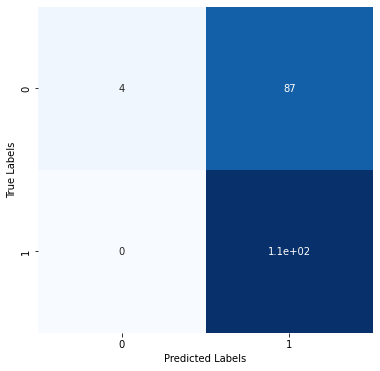

In [257]:
print(f"Evaluation du modèle : {simple_model.evaluate(X_test, y_test)}")
y_pred = simple_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Tous les modèles

### Entrainement des modèles pour chaque dataset

In [ ]:
# attack_types = [13, 14, 15, 18, 19]
attack_types = [13, 14]
# dataframes = [df_13, df_14, df_15, df_18, df_19]
dataframes = [df_13, df_14]

In [ ]:
EPOCHS = 20
VAL_SPLIT = 0.3
ADAM = keras.optimizers.Adam(learning_rate=0.0003)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

In [ ]:
evaluation_dataframe = pd.DataFrame()
for i in range(len(dataframes)):
    X_train, X_test, y_train, y_test = dataset_prep.data_preparation(dataframes[i], sample=False)

    # 2-stacked RNN
    print("\nTraining 2 stacked RNN model\n")
    rnn_model = stacked_RNN_small(input_sequence_shape=input_sequence_shape)
    rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
    history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=rnn_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])

    # stacked LSTM small
    print("\nTraining stacked small LSTM model\n")
    lstm_model = stacked_LSTM_small(input_sequence_shape)
    opt = keras.optimizers.SGD(learning_rate=0.01)
    lstm_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=lstm_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['stacked-small-lstm'], 'accuracy':[eval[1]]})])

    # mix lstm rnn
    print("\nTraining RNN-LSTM model\n")
    lstm_rnn_model = mix_rnn_lstm(input_sequence_shape)
    opt = keras.optimizers.SGD(learning_rate=0.01)
    lstm_rnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    history = lstm_rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=lstm_rnn_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['lstm-rnn'], 'accuracy':[eval[1]]})])

    # 3 Stacked GRU
    print("\nTraining 3 stacked GRU\n")
    stacked_GRU_model = stacked_GRU(input_sequence_shape)
    opt = keras.optimizers.SGD(learning_rate=0.01)
    stacked_GRU_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    history = stacked_GRU_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=stacked_GRU_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['3-stacked-GRU'], 'accuracy':[eval[1]]})])

    # simple GRU
    print("\nTraining simple GRU\n")
    simple_GRU_model = simple_GRU(input_sequence_shape)
    opt = keras.optimizers.SGD(learning_rate=0.01)
    simple_GRU_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    history = simple_GRU_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=simple_GRU_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['simple-gru'], 'accuracy':[eval[1]]})])

    # stacked LSTM
    print("\nTraining 3 stacked LSTM\n")
    stacked_LSTM_model = stacked_LSTM(input_sequence_shape)
    stacked_LSTM_model.compile(loss='mean_absolute_error', optimizer=ADAM, metrics='accuracy')
    history = stacked_LSTM_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=64, validation_split=VAL_SPLIT, callbacks=[callback])
    eval = stacked_LSTM_model.evaluate(X_test, y_test)
    evaluation_dataframe = pd.concat([evaluation_dataframe, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['3-stacked-LSTM'], 'accuracy':[eval[1]]})])

# Modèle de littérature

### Préparation des données 

Modèle CNN LSTM

In [ ]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = dataset_prep.data_preparation_cnnlstm(df, sample=False)

In [ ]:
#input shape cnn lstm : X_train.shape[1:]
litterature_model = CNN_LSTM_1(X_train.shape[1:])

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = litterature_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.3, callbacks=[callback])

In [ ]:
print(f"Evaluation du modèle : {litterature_model.evaluate(X_test, y_test)}")

y_pred = litterature_model.predict(X_test)
preds = np.round(y_pred).astype(int)

cm = confusion_matrix(y_test, preds, normalize='all')
fig, ax = plt.subplots(figsize=(6,6)) 

sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()

### Entrainement des modèles de littérature 

In [ ]:
EPOCHS = 20
VAL_SPLIT = 0.3
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

evaluation_litterature = pd.DataFrame()
for i in range(len(dataframes)):
    X_train, X_test, y_train, y_test = dataset_prep.data_preparation(dataframes[i], sample=False)

    # CNN LSTM n°2
    # 43%
    print("\nTraining CNN_LSTM_2 model\n")
    CNN_LSTM_2_model = CNN_LSTM_2(input_sequence_shape=X_train.shape[1:])
    history = CNN_LSTM_2_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=CNN_LSTM_2_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    
    # 3 stacked LSTM
    #83,50%
    print("\nTraining 3_LSTM model\n")
    three_LSTM_model = three_LSTM(input_sequence_shape=X_train.shape[1:])
    history = three_LSTM_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=three_LSTM_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    
    # 4 stacked LSTM
    #83,79%
    print("\nTraining 4_LSTM model\n")
    four_LSTM_model = four_LSTM(input_sequence_shape=X_train.shape[1:])
    history = four_LSTM_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=four_LSTM_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    
    # 5 stacked LSTM
    #83,57%
    print("\nTraining 5_LSTM model\n")
    five_LSTM_model = five_LSTM(input_sequence_shape=X_train.shape[1:])
    history = five_LSTM_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=five_LSTM_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    
    # 4 stacked LSTM n°2
    #83,59%
    print("\nTraining LSTM model\n")
    LSTM_model = LSTM_1(input_sequence_shape=X_train.shape[1:])
    history = LSTM_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=LSTM_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    
    # CNN LSTM n°3
    #44,06%
    print("\nTraining CNN_LSTM_3 model\n")
    CNN_LSTM_3_model = CNN_LSTM_3(input_sequence_shape=X_train.shape[1:])
    history = CNN_LSTM_3_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=128, validation_split=VAL_SPLIT, callbacks=[callback])
    eval=CNN_LSTM_3_model.evaluate(X_test, y_test)
    evaluation_litterature = pd.concat([evaluation_litterature, pd.DataFrame({'dataset':[attack_types[i]], 'modele':['2-stacked-rnn'], 'accuracy':[eval[1]]})])
    

In [ ]:
evaluation_litterature.to_csv('results_litterature.csv')